In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

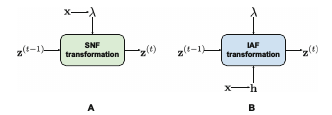

Fig.15 Diﬀerent amortization strategies for Sylvester normalizing ﬂows and inverse autore- gressive ﬂows (a) Our inference network produces amortized ﬂow parameters. This strategy is also employed by planar ﬂows. (b) Inverse autoregressive ﬂow [18] introduces a measure of .x dependence through a context variable .h(x). This context acts as an additional input for each transformation. The ﬂow parameters themselves are independent of .x.

## Amortizing Flow Parameters

When using normalizing flows in an amortized inference setting, the parameters of the base distribution as well as the flow parameters can be functions of the data point $ \mathbf{x} $ [19]. Figure 5.15 (left) shows a diagram of one Sylvester Normalizing Flow (SNF) step and the amortization procedure.

The inference network takes datapoints $ \mathbf{x} $ as input and provides as an output the mean and variance of $ \mathbf{z}^{(0)} $, such that $ \mathbf{z}^{(0)} \sim \mathcal{N}(\mathbf{z} | \mu_0, \sigma_0) $. Several SNF transformations are then applied to $ \mathbf{z}^{(0)} \rightarrow \mathbf{z}^{(1)} \rightarrow \dots \rightarrow \mathbf{z}^{(T)} $, producing a flexible posterior distribution for $ \mathbf{z}^{(T)} $. 

All of the flow parameters $ (\mathbf{R}, \mathbf{R}^\sim, \mathbf{Q}) $ for each transformation are produced as an output by the inference network and are thus fully amortized.

### Different Amortization Strategies
1. **Amortized Flow Parameters (SNF)**: Our inference network produces amortized flow parameters. This strategy is also employed by planar flows.
2. **Inverse Autoregressive Flow (IAF)**: The inverse autoregressive flow [18] introduces a measure of $ \mathbf{x} $-dependence through a context variable $ h(\mathbf{x}) $. This context acts as an additional input for each transformation, and the flow parameters themselves are independent of $ \mathbf{x} $.

---

## Hyperspherical Latent Space

### Motivation

In the VAE framework, choosing Gaussian priors and Gaussian posteriors for mathematical convenience leads to a Euclidean latent space. However, this choice could be limiting for the following reasons:

- **Low-Dimensional Issues**: In low dimensions, the standard Gaussian probability presents a concentrated probability mass around the mean, encouraging points to cluster at the center. This becomes problematic when the data is divided into multiple clusters. A better-suited prior would be uniform, but this is not well-defined on the hyperplane.
- **High-Dimensional Issues**: The standard Gaussian distribution in high dimensions tends to resemble a uniform distribution on the surface of a hypersphere, with the majority of its mass concentrated on the hyperspherical shell (the "soap bubble" effect).

A natural question is whether it would be better to use a distribution defined on the hypersphere. One such distribution that solves both problems is the **von-Mises-Fisher (vMF)** distribution.

### von-Mises-Fisher Distribution

The von-Mises-Fisher (vMF) distribution is often described as the Gaussian distribution on a hypersphere. Analogous to a Gaussian, it is parameterized by $ \mu $ (mean direction) and $ \kappa \in \mathbb{R}, \mu \in \mathbb{R}^{\geq 0} $. For the special case of $ \kappa = 0 $, the vMF represents a uniform distribution.

The probability density function of the vMF distribution for a random unit vector $ \mathbf{z} \in \mathbb{R}^m $ (or $ \mathbf{z} \in S^{m-1} $) is:

$$
q(\mathbf{z} | \mu, \kappa) = C_m (\kappa) \exp \left( \kappa \mu^T \mathbf{z} \right)
$$

where:

$$
C_m (\kappa) = \frac{\kappa^{\frac{m}{2} - 1}}{(2\pi)^{\frac{m}{2}} I_{\frac{m}{2}-1} (\kappa)}
$$

Here, $ I_v(\kappa) $ is the modified Bessel function of the first kind at order $ v $, and $ \| \mu \|_2 = 1 $.

Interestingly, since we define a distribution over a hypersphere, it is possible to formulate a uniform prior over the hypersphere. Using the vMF distribution as the variational posterior, the Kullback-Leibler (KL) divergence between the vMF distribution and the uniform distribution over $ S^{m-1} $ can be calculated analytically as:

$$
KL[vMF(\mu, \kappa) || Unif(S^{m-1})] = \frac{1}{2} \kappa + \log C_m (\kappa) - \log \Gamma\left( \frac{m}{2} \right)
$$

### Sampling from vMF

Sampling from the von-Mises-Fisher distribution requires the acceptance-rejection sampling procedure. The reparameterization trick can be extended to distributions that can be simulated via rejection sampling, as shown in [62].

This allows the creation of a **Hyperspherical VAE** that can efficiently model latent space on the hypersphere, making it more appropriate for complex, multi-modal data distributions.

For further details and the reparameterization trick, refer to [33] and [62].


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class InferenceNetwork(nn.Module):
    def __init__(self, input_dim, flow_dim):
        super(InferenceNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, flow_dim)  # Mean for z(0)
        self.fc_sigma = nn.Linear(64, flow_dim)  # Variance for z(0)
        self.fc_R = nn.Linear(64, flow_dim)  # Flow parameter R
        self.fc_Q = nn.Linear(64, flow_dim)  # Flow parameter Q

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = self.fc_mu(x)
        sigma = self.fc_sigma(x)
        R = self.fc_R(x)
        Q = self.fc_Q(x)
        return mu, sigma, R, Q
def snf_flow(z, R, Q, h, num_steps=5):
    """
    Applies Sylvester normalizing flow (SNF) to the latent vector z
    using flow parameters R, Q, and a function h (activation).
    """
    for _ in range(num_steps):
        Rz = torch.matmul(R, z)  # R * z(t-1)
        h_Rz = h(Rz)  # Apply activation
        z = z + torch.matmul(Q, h_Rz)  # z(t) = z(t-1) + Q * h(R * z(t-1))
    return z
import math
import torch
from torch.distributions import Distribution

class vonMisesFisher(Distribution):
    def __init__(self, mu, kappa):
        self.mu = mu  # Mean direction (normalized)
        self.kappa = kappa  # Concentration parameter
        self.dim = mu.size(0)  # Dimensionality of the latent space

    def log_prob(self, z):
        """
        Compute the log probability of a point z under the vMF distribution.
        """
        dot_product = torch.matmul(self.mu, z)
        normalization_constant = self._log_normalizing_constant(self.kappa)
        return self.kappa * dot_product - normalization_constant

    def _log_normalizing_constant(self, kappa):
        """
        Compute the log normalizing constant of the vMF distribution.
        """
        return (self.dim / 2 - 1) * torch.log(kappa) - self._log_bessel(self.dim / 2 - 1, kappa)

    def _log_bessel(self, v, kappa):
        """
        Compute the log Bessel function for the given order v and parameter kappa.
        """
        # Use an approximation or numerical implementation of the Bessel function
        return torch.log(torch.i0(kappa))

    def sample(self):
        """
        Sample from the von-Mises-Fisher distribution using rejection sampling.
        """
        # Implement the acceptance-rejection procedure for sampling from vMF
        pass
class HypersphericalVAE(nn.Module):
    def __init__(self, input_dim, flow_dim):
        super(HypersphericalVAE, self).__init__()
        self.inference_network = InferenceNetwork(input_dim, flow_dim)
        self.z0_dim = flow_dim  # Dimensionality of the latent variable
        self.flow = snf_flow
        self.mu_prior = torch.zeros(flow_dim)  # Prior mean (centered at origin)
        self.kappa_prior = 1.0  # Prior concentration

    def encode(self, x):
        """
        Encode input x into the parameters for the prior distribution and flow.
        """
        mu, sigma, R, Q = self.inference_network(x)
        return mu, sigma, R, Q

    def decode(self, z):
        """
        Decode latent variable z back into the original space (e.g., reconstruction).
        """
        # Implement decoder network if needed (not shown here)
        return z

    def forward(self, x):
        """
        Perform forward pass: encoding, SNF flow, and decoding.
        """
        mu, sigma, R, Q = self.encode(x)
        z = mu + sigma * torch.randn_like(mu)  # Sampling from N(mu, sigma)
        z_transformed = self.flow(z, R, Q, torch.relu)
        return self.decode(z_transformed)

    def loss_function(self, x, z):
        """
        Compute the loss function, which includes KL divergence and reconstruction loss.
        """
        # Prior distribution (vMF)
        vMF_dist = vonMisesFisher(self.mu_prior, self.kappa_prior)
        log_p_z = vMF_dist.log_prob(z)

        # Likelihood of data given z (reconstruction term)
        # Use reconstruction loss (e.g., MSE, CrossEntropy, depending on data)
        reconstruction_loss = torch.mean((x - self.decode(z)) ** 2)

        # Total loss = reconstruction loss + KL divergence
        return reconstruction_loss - torch.mean(log_p_z)

# Example training loop
input_dim = 20  # Example input dimension
flow_dim = 10   # Latent dimension
vae = HypersphericalVAE(input_dim, flow_dim)

# Example optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Dummy input data
x_data = torch.randn(64, input_dim)  # Batch of 64 samples, each of dimension input_dim

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    z = vae(x_data)  # Forward pass
    loss = vae.loss_function(x_data, z)  # Calculate loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
